# Install and Import Required Libraries

## Install

In [ ]:
!pip install hazm
!pip install stanfordnlp
!pip install -U nltk
!pip install pandas
!pip install sklearn
!pip install numpy
!pip install torch

     |████████████████████████████████| 317kB 5.4MB/s 
     |████████████████████████████████| 235kB 12.8MB/s 
     |████████████████████████████████| 1.4MB 19.2MB/s 
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp36-cp36m-linux_x86_64.whl size=154769 sha256=98588fdfd9d4db78546544a3329562ddbaf6b77d9f6dcf38464dfb8cfc381b7e
  Stored in directory: /root/.cache/pip/wheels/66/15/54/4510dce8bb958b1cdd2c47425cbd1e1eecc0480ac9bb1fb9ab
  Created wheel for nltk: filename=nltk-3.3-cp36-none-any.whl size=1394471 sha256=abdbe0fb8cae0f80e5d40fbb5caa9e1ae4a9d8142122ad80b71821fd8e1e84b5
  Stored in directory: /root/.cache/pip/wheels/d1/ab/40/3bceea46922767e42986aef7606a600538ca80de6062dc266c
Successfully built libwapiti nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
     |████████████████████████████████| 163kB 4.9MB/s 
     |████████████████████████████████| 1.4MB 4.5MB/s 
  Created wheel for nltk: filename=nltk-3.5-cp3

## Import

In [ ]:
import nltk
# nltk.download('punkt')
from nltk import word_tokenize as nltk_word_tokenize
import string
import pandas as pd
from hazm import *
import re
import numpy as np
from pathlib import Path
from google.colab import drive
import torch
import stanfordnlp

import sklearn
from sklearn.model_selection import train_test_split

import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
import stanfordnlp
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

import os.path
import joblib

from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras import optimizers
from keras.models import Model, load_model
from keras.layers.merge import concatenate
from keras.layers import Embedding, Input
from IPython.display import clear_output
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, concatenate 
from keras import regularizers
import matplotlib.pyplot as plot
from keras.utils import plot_model

from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l1, l2
from keras import regularizers
from keras import metrics
from keras import backend as K
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Import my class from google drive

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

FeatureExtractor = drive.CreateFile({'id':'1IwEfIW-lYHvGSSr6TwMsGX3xX1Z829cP'})
FeatureExtractor.GetContentFile('psfeatureextractor.py')
from psfeatureextractor import PSFeatureExtractor as FeatureExtractor

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Common Functions and Variables

In [ ]:
stanford_models_path  = '/content/drive/My Drive/Stance Detection Paper/persian_stance_baseline_data/' 
dataset_path = '/content/drive/My Drive/Stance Detection Paper/HeadlineToClaim.csv'
stopWord_path = '/content/drive/My Drive/ImportantNLPFiles/StopWords_fa.txt'
polarity_dataset_path = '/content/drive/My Drive/Stance Detection Paper/PolarityDataset.xlsx'
save_load_path = "/content/drive/My Drive/Stance Detection Paper/persian_stance_baseline_data/vectors"
w2v_model_path = "/content/drive/My Drive/Stance Detection Paper/persian_stance_baseline_data/vectors/w2v_persian.pkl"
train_test_sets_save_path = "/content/drive/My Drive/Stance Detection Paper/persian_stance_baseline_data"
train_test_sets_load_path = "/content/drive/My Drive/Stance Detection Paper/persian_stance_baseline_data"

EMBEDDING_DIM = 300
Claim_Max_Sequence_Length= 15
Headline_Max_Sequence_Length= 15
Max_Sequence_Length = Claim_Max_Sequence_Length + Headline_Max_Sequence_Length
Number_Of_Class = 4

In [ ]:
def recall_m(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Convert labels to one hot

In [ ]:
def convert_to_one_hot(y_train, number_of_class):
  y_train_temp = np.zeros((y_train.shape[0], number_of_class), dtype=np.int)

  for i,label in enumerate(y_train):
    if(label == 'Agree'):
      y_train_temp[i] = [1,0,0,0]
    elif (label == 'Disagree'):
      y_train_temp[i] = [0,1,0,0]
    elif (label == 'Discuss'):
      y_train_temp[i] = [0,0,1,0]
    else :
      y_train_temp[i] = [0,0,0,1]
  return y_train_temp

## Model

In [ ]:
# Create And Run Model
def create_model(batch_size =100, kernel_initializer= 'glorot_uniform', regularizer = None
                 , dense_activity_regularizer=None, LSTM_implementation = 2, epochs = 70
                 , dense_dropout = [0.5], lstm_dropout = [0.2], dense_neroun_count = [600]
                 , lstm_neroun_count = [100], dense_activation = ['relu'] ,optimizer = 'adam'
                 , other_feature_length= 10, print_summary= True):

  # combi_input = Input((2,)) # (None, 3)
  # a_input = Lambda(lambda x: tf.expand_dims(x[:,0],-1))(combi_input) # (None, 1) 
  # b_input = Lambda(lambda x: tf.expand_dims(x[:,1],-1))(combi_input) # (None, 1)   

  lstm_input = Input(shape=(Max_Sequence_Length,), dtype='int32', name='lstm_input') # receive sequences of Max_Sequence_Length integers

  print('EMBEDDING_DIM: ',EMBEDDING_DIM)
  print('embedding_matrix shape: ',embedding_matrix.shape)
  print('Max_Sequence_Length: ',Max_Sequence_Length)

  embedding = Embedding(input_dim=len(embedding_matrix), # lookup table size Max_Sequence_Length
                                      output_dim=EMBEDDING_DIM, # output dim for each number in a sequence
                                      weights=[embedding_matrix],
                                      input_length=Max_Sequence_Length, # receive sequences of Max_Sequence_Length integers
                                      mask_zero=True,
                                      trainable=True)(lstm_input)

  lstm1_neroun_count = lstm_neroun_count[0]  
  lstm2_neroun_count = lstm_neroun_count[0]
  
  if(len(lstm_neroun_count)>1):
    lstm2_neroun_count = lstm_neroun_count[1]
  print('lstm1_neroun_count:', lstm1_neroun_count , 'lstm2_neroun_count:',lstm2_neroun_count)
  # ------------
  lstm1_dropout = lstm_dropout[0]  
  lstm2_dropout = lstm_dropout[0]
  
  if(len(lstm_dropout)>1):
    lstm2_dropout = lstm_dropout[1]
  print('lstm1_dropout:', lstm1_dropout , 'lstm2_dropout:',lstm2_dropout)
  # ------------
  
  data_LSTM = LSTM(lstm1_neroun_count, return_sequences=True, stateful=False, dropout= lstm1_dropout,
              batch_input_shape=(batch_size, Max_Sequence_Length, EMBEDDING_DIM),
              input_shape=(Max_Sequence_Length, EMBEDDING_DIM), implementation= LSTM_implementation
              )(embedding)
  data_LSTM = LSTM(lstm2_neroun_count, return_sequences=False, stateful=False, dropout= lstm2_dropout,
              batch_input_shape=(batch_size, Max_Sequence_Length, EMBEDDING_DIM),
              input_shape=(Max_Sequence_Length, EMBEDDING_DIM), implementation= LSTM_implementation
              )(data_LSTM)

  ###############################
  # MLP (NON-TIMESTEP) FEATURES #
  ###############################

  mlp_input = Input(shape=(int(other_feature_length),), dtype='float32', name='mlp_input')

  ###############
  # MERGE LAYER #
  ###############
  merged = concatenate([data_LSTM, mlp_input])

  dense1_neroun_count = dense_neroun_count[0]  
  dense2_neroun_count = dense_neroun_count[0]
  dense3_neroun_count = dense_neroun_count[0]
  
  if(len(dense_neroun_count)>1):
    dense2_neroun_count = dense_neroun_count[1]
    
  if(len(dense_neroun_count)>2):
    dense3_neroun_count = dense_neroun_count[2]    
  print('dense1_neroun_count:', dense1_neroun_count , 'dense2_neroun_count:',dense2_neroun_count,'dense3_neroun_count:',dense3_neroun_count)
  #-----------------------
  dense1_dropout = dense_dropout[0]  
  dense2_dropout = dense_dropout[0]
  dense3_dropout = dense_dropout[0]
  
  if(len(dense_dropout)>1):
    dense2_dropout = dense_dropout[1]
    
  if(len(dense_dropout)>2):
    dense3_dropout = dense_dropout[2]    
  print('dense1_dropout:', dense1_dropout , 'dense2_dropout:',dense2_dropout,'dense3_dropout:',dense3_dropout)
  #-----------------------  
  dense1_activation = dense_activation[0]  
  dense2_activation = dense_activation[0]
  dense3_activation = dense_activation[0]
  
  if(len(dense_activation)>1):
    dense2_activation = dense_activation[1]
    
  if(len(dense_activation)>2):
    dense3_activation = dense_activation[2]    
  print('dense1_activation:', dense1_activation , 'dense2_activation:',dense2_activation,'dense3_activation:',dense3_activation)  
  #-----------------------

  dense_mid = Dense(dense1_neroun_count, kernel_regularizer=regularizer, kernel_initializer=kernel_initializer,
                            activity_regularizer=dense_activity_regularizer, activation= dense1_activation)(merged)
  dense_mid = Dropout(dense1_dropout)(dense_mid)
  dense_mid = Dense(dense2_neroun_count, kernel_regularizer=regularizer, kernel_initializer=kernel_initializer,
                            activity_regularizer=dense_activity_regularizer, activation= dense2_activation)(dense_mid)
  dense_mid = Dropout(dense2_dropout)(dense_mid)
  dense_mid = Dense(dense3_neroun_count, kernel_regularizer=regularizer, kernel_initializer=kernel_initializer,
                            activity_regularizer=dense_activity_regularizer, activation= dense3_activation)(dense_mid)
  dense_mid = Dropout(dense3_dropout)(dense_mid)
  dense_out = Dense(4,activation='softmax', name='dense_out')(dense_mid)

  # model = Model(combi_input, outputs=[dense_out])
  # build model
  model = Model(inputs=[lstm_input, mlp_input], outputs=[dense_out])

  # compile model
  model.compile(optimizer, 'kullback_leibler_divergence', # categorial_crossentropy
                             metrics=['accuracy',f1_score_m,precision_m, recall_m])
  if print_summary:
    # print summary
    model.summary()
    plot_model(model, to_file='model.png')
  
  return model

In [ ]:
# train_inputs = [LSTM_input_train, MLP_input_train]
# train_labels = y_train_one_hot
# validation_inputs = [LSTM_input_test, MLP_input_test]
# validation_labels = y_test_one_hot
def run_model(train_inputs, train_labels, validation_inputs, validation_labels ,batch_size =100, kernel_initializer= 'glorot_uniform', regularizer = None
                 , dense_activity_regularizer=None, LSTM_implementation = 2, epochs = 70
                 , dense_dropout = [0.5], lstm_dropout = [0.2], dense_neroun_count = [600]
                 , lstm_neroun_count = [100], dense_activation = ['relu'], optimizer = 'adam'
                 , other_feature_length= 10, print_summary= True, patience = 1, verbose= 1, save_path = ''):

  model = create_model(batch_size, kernel_initializer, regularizer
                 , dense_activity_regularizer, LSTM_implementation, epochs
                 , dense_dropout, lstm_dropout, dense_neroun_count
                 , lstm_neroun_count, dense_activation, optimizer, len(train_inputs[1][0]), print_summary)

  best_model_path = save_path + 'best_model.hdf5'
  callbacks_list = [
    EarlyStopping(monitor='val_loss', patience = patience),
    ModelCheckpoint(filepath= save_path + best_model_path, save_best_only=True ,monitor='val_loss' )
  ]

  history = model.fit(train_inputs,
                             train_labels,
                             validation_data=(validation_inputs, validation_labels),
                             batch_size=batch_size, epochs=epochs, verbose= verbose, callbacks = callbacks_list)
  
  # plot history 
  print('----------------------- History for accuracy -------------------------')
  # summarize history for accuracy
  plot.plot(history.history['accuracy'], label='train')
  plot.plot(history.history['val_accuracy'], label='test')
  plot.legend()
  plot.show()

  print('----------------------- History for f1_score -------------------------')
  # summarize history for accuracy
  plot.plot(history.history['f1_score_m'], label='train')
  plot.plot(history.history['val_f1_score_m'], label='test')
  plot.legend()
  plot.show()
  
  print('----------------------- Metrics for the last epoch -------------------------')
  print('Accuracy of train is :',history.history['accuracy'][-1])
  print('Loss of train is :',history.history['loss'][-1])
  print('f1_score of train is :',history.history['f1_score_m'][-1])
  print('recall of train is :',history.history['recall_m'][-1])
  print('precision of train is :',history.history['precision_m'][-1])
  print('--------')
  print('Accuracy of test is :',history.history['val_accuracy'][-1])
  print('Loss of test is :',history.history['val_loss'][-1])  
  print('f1_score of test is :',history.history['val_f1_score_m'][-1])
  print('recall of test is :',history.history['val_recall_m'][-1])
  print('precision of test is :',history.history['val_precision_m'][-1])
  print('----------------------- Metric for the best epoch -------------------------')

  best_model = load_model(best_model_path, custom_objects={'f1_score_m': f1_score_m, 'precision_m':precision_m, 'recall_m':recall_m})
  
  best_model_predictions = best_model.predict(validation_inputs)
  
  # loss, accuracy, f1_score, precision, recall = best_model.evaluate(validation_inputs, validation_labels, verbose=0)

  # print('Accuracy: %f' % accuracy)

  # # precision tp / (tp + fp)
  # print('Precision: %f' % precision)

  # # recall: tp / (tp + fn)
  # print('Recall: %f' % recall)

  # # f1: 2 tp / (2 tp + fp + fn)
  # print('F1 score: %f' % f1_score)

  conf = confusion_matrix(np.argmax(validation_labels,axis=1),np.argmax(best_model_predictions,axis=1))
  print(conf)
  plt.imshow(conf)
  best_model_precesion = np.diag(conf) / np.sum(conf,axis=0)
  best_model_recall= np.diag(conf) / np.sum(conf,axis=1)
  print('Precesion: ', best_model_precesion) # calculate precesion یعنی دقت
  print('Recall: ', best_model_recall) # calculate recall یعنی صحت
  # باید هر دو بالا باشن؛ که ضرب این دو معیار اف وان می شود
  print('F1_score: ' + str(2*((best_model_precesion*best_model_recall)/(best_model_precesion+best_model_recall+K.epsilon()))))
  print('Accuracy: ',np.sum(np.diag(conf)) / np.sum(conf)) # accuracy
  
  return history, best_model_predictions

## Load Embedding and Create Embedding Matrix

In [ ]:
def has_key(dict, key):
  if key in dict.keys():
    return True
  return False

In [ ]:
def load_embedding_file(file_path, save_result = True,
                                 save_path= '', load_if_exist= True):

  embeddings_index = dict()
  embeddings_index_path = save_path + '/embeddings_index.pkl'
  if os.path.isfile(embeddings_index_path) == True and load_if_exist :
    embeddings_index = joblib.load(embeddings_index_path)
    print('embeddings_index loaded successfully.')
  else:
    f = open(file_path, mode="r", encoding="utf-8",errors='ignore')
    for line in f:
        try:
          values = line.split()
          word = values[0]
          coefs = np.asarray(values[1:], dtype='float32')
          embeddings_index[word] = coefs
        except:
          a=0
    f.close()
    print('embeddings_index created successfully.')
  if save_result:
    joblib.dump(embeddings_index, embeddings_index_path)
    print('embeddings_index saved successfully.')
  return embeddings_index

In [ ]:
# all words available in target dataset
def create_embedding_matrix(embeddings_index, dataset_words, embedding_dim = 100, save_result = True,
                                 save_path= '', load_if_exist= True):
  not_exist_count = 0
  embedding_matrix = []
  embeddings_index_dict = dict()
  embed_count = 0  
  repeat_counts = 0

  embedding_matrix.append(np.zeros((1, int(embedding_dim))))
  embeddings_index_dict['UNKNOWN'] = embedding_matrix[0]

  embedding_matrix_path = save_path + '/embedding_matrix.pkl'
  if os.path.isfile(embedding_matrix_path) == True and load_if_exist:
    embedding_matrix = joblib.load(embedding_matrix_path)
    print('embeddings_index loaded successfully.')
    return embedding_matrix
  else:
    for i, record in enumerate(dataset_words):
      for token in record:
        try:
          if has_key(embeddings_index_dict, token) != True:
            embed_array = np.zeros((1, int(embedding_dim)))
            embed_array = embeddings_index[token]
            embeddings_index_dict[token] = embed_array
            embedding_matrix.append(embed_array)
            embed_count +=1
          else:
            repeat_counts +=1
        except:
          # print(token + ' Not Exist.')
          not_exist_count += 1
    print('Not exist count: ' + str(not_exist_count))
    print('embedding_matrix created successfully.')
    # embedding_matrix = np.asarray(embedding_matrix)  
    embedding_matrix = np.vstack( embedding_matrix)
    print('embedded tokens  count: '+ str(embed_count))
    print('repeat_counts: '+ str(repeat_counts))
    print('Loaded %s word vectors.' % embedding_matrix.shape[0])

  if save_result:         
    joblib.dump(embedding_matrix, embedding_matrix_path)
    print('embedding_matrix saved successfully.')          

  return embedding_matrix, embeddings_index_dict

## Create Sequence Index of Embedding

In [ ]:
def create_sequence_index_feature(embedding_dict, claims_tokens, headlines_tokens, save_result = True,
                                 save_path= '', load_if_exist= True):
  
  claim_tokens_index_array_path = save_path + '/claim_tokens_index_array.pkl'
  headline_tokens_index_array_path = save_path + '/headline_tokens_index_array.pkl'
  if os.path.isfile(claim_tokens_index_array_path) == True and os.path.isfile(headline_tokens_index_array_path) == True and load_if_exist :
    claim_tokens_index_array= joblib.load(claim_tokens_index_array_path)
    headline_tokens_index_array= joblib.load(headline_tokens_index_array_path)
    print('sequence_index_feature loaded successfully.')
    return claim_tokens_index_array, headline_tokens_index_array

  not_existCount = 0
  claim_tokens_index_array = np.zeros((len(claims_tokens), Claim_Max_Sequence_Length))
  headline_tokens_index_array = np.zeros((len(headlines_tokens), Headline_Max_Sequence_Length))
  load_embedding_list = list(embedding_dict.items()) 

  for i,claim in enumerate(claims_tokens):
    # ------------------  create claim sequence index of embedding ----------------
    claim_tokens = claim[0]
    for j,token in enumerate(claim_tokens):
      if Claim_Max_Sequence_Length == j:
        break
      try:
        claim_tokens_index_array[i,j] = [idx for idx, key in enumerate(load_embedding_list) if key[0] == token][0]
      except:
        claim_tokens_index_array[i,j] = 0
        not_existCount +=1
        pass
  # ----------------------------------
  for i,headline in enumerate(headlines_tokens):
    # ------------------ create headline sequence index of embedding ----------------
    headline_tokens = headline[0]
    for j,token in enumerate(headline_tokens):
      if Headline_Max_Sequence_Length == j:
        break
      try:
        headline_tokens_index_array[i,j] = [idx for idx, key in enumerate(load_embedding_list) if key[0] == token][0]
      except:
        headline_tokens_index_array[i,j] = 0
        not_existCount +=1
        pass    
  print('claim_tokens_index_array shape is : ', claim_tokens_index_array.shape)
  print('headline_tokens_index_array shape is : ', headline_tokens_index_array.shape)

  return claim_tokens_index_array, headline_tokens_index_array

## Create Feature Extractor Object

In [ ]:
psf_extractor = FeatureExtractor(dataset_path = dataset_path, stopWord_path = stopWord_path
                                    , polarity_dataset_path = polarity_dataset_path,
                                  stanford_models_path = stanford_models_path
                                  ,use_google_drive = True, important_words = ['؟',
             'تکذیب',
             'تکذیب شد',
             ':',
             ])

tokens_claims , tokens_headlines = psf_extractor.nltk_tokenize()

Mounted at /content/drive
/content/drive/My Drive/ImportantNLPFiles/StopWords_fa.txt
(2029,) (2029,) (2029,) (2029,) (2029,)


In [ ]:
labels = np.reshape(psf_extractor.labels,(len(psf_extractor.labels),1))
labels.shape

(2029, 1)

# LSTM With Other Features

## Extract Feature

In [ ]:
features, features_name = psf_extractor.generate_Features(w2v_model_path = w2v_model_path,save_path = save_load_path
                                                          , save_feature= False
                                                          , load_path= save_load_path
                                                          , load_if_exist = False, tfidf = False, bow = True, w2v = False
                                                          , polarity= False)
 
print('Features: '+features_name)
print('The shape of manually extracted features is: ' + str(features.shape))

In [ ]:
dataset_tokens_list = []
dataset_tokens_list.extend(psf_extractor.tokens_claims)
dataset_tokens_list.extend(psf_extractor.tokens_headlines)
len(dataset_tokens_list)

4058

### Load Embedding and create embedding matrix

In [ ]:
# Load Embedding and create embedding matrix
model_path = "/content/drive/My Drive/Stance Detection Paper/persian_stance_baseline_data/vectors/cc.fa.300.vec"
# model_path = "/content/drive/My Drive/wiki.txt"

embedding_dict = load_embedding_file(model_path, save_result = False,
                                 save_path= '', load_if_exist= False)
# wiki.txt=  248660, 100
print('embedding_dict''s length is: ' + str(len(embedding_dict)))

embeddings_index created successfully.
embedding_dicts length is: 2000000


In [ ]:
embedding_matrix, embedding_matrix_dict =create_embedding_matrix(embedding_dict
                                                                ,dataset_words = dataset_tokens_list
                                                                , embedding_dim= EMBEDDING_DIM
                                                                , save_result = False
                                                                ,save_path= "/content/drive/My Drive/Stance Detection Paper/persian_stance_baseline_data/vectors/"
                                                                , load_if_exist= False)

Not exist count: 603
embedding_matrix created successfully.
embedded tokens  count: 4332
repeat_counts: 24945
Loaded 4333 word vectors.


In [ ]:
print(embedding_matrix.shape)

len(embedding_matrix_dict)

(4333, 300)


4333

### Create Sequence Index Feature

In [ ]:
# Create Sequence Index Feature
claim_tokens_index_array, headline_tokens_index_array = create_sequence_index_feature(embedding_matrix_dict
                                                                                      , psf_extractor.tokens_claims
                                                                                      , psf_extractor.tokens_headlines
                                                                                      , save_result = False
                                                                                      ,save_path= "/content/drive/My Drive/Stance Detection Paper/persian_stance_baseline_data/vectors/"
                                                                                      , load_if_exist= False)



claim_tokens_index_array shape is :  (2029, 15)
headline_tokens_index_array shape is :  (2029, 15)


### Concatenate all Features

In [ ]:
all_features = np.concatenate((claim_tokens_index_array, headline_tokens_index_array, features), axis=1)
print('concatenate all features.')

print('All features shape is: ' + str(all_features.shape))

concatenate all features.
All features shape is: (2029, 20390)


## Prepare Data and Labels

In [ ]:
train,test,y_train,y_test = train_test_split(all_features,psf_extractor.labels ,test_size=0.2, random_state=42)
print('train.shape = ', train.shape)
print('y_train.shape = ', y_train.shape)
print('test.shape = ', test.shape)
print('y_test.shape = ', y_test.shape)

LSTM_input_train = train[:, 0:30]
LSTM_input_test = test[:, 0:30]
MLP_input_train = train[:, 30:]
MLP_input_test = test[:, 30:]

print('LSTM_input_train.shape : ',LSTM_input_train.shape)
print('LSTM_input_test.shape : ',LSTM_input_test.shape)
print('MLP_input_train.shape : ',MLP_input_train.shape)
print('MLP_input_test.shape : ',MLP_input_test.shape)

train.shape =  (1623, 20390)
y_train.shape =  (1623,)
test.shape =  (406, 20390)
y_test.shape =  (406,)
LSTM_input_train.shape :  (1623, 30)
LSTM_input_test.shape :  (406, 30)
MLP_input_train.shape :  (1623, 20360)
MLP_input_test.shape :  (406, 20360)


In [ ]:
y_train_one_hot = convert_to_one_hot(y_train, Number_Of_Class)
y_test_one_hot = convert_to_one_hot(y_test, Number_Of_Class)
y_train_one_hot
# ,y_test

array([[0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       ...,
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1]])

## Run the Model

Type 1
EMBEDDING_DIM:  300
embedding_matrix shape:  (4333, 300)
Max_Sequence_Length:  30
lstm1_neroun_count: 100 lstm2_neroun_count: 100
lstm1_dropout: 0.5 lstm2_dropout: 0.5
dense1_neroun_count: 600 dense2_neroun_count: 600 dense3_neroun_count: 600
dense1_dropout: 0.5 dense2_dropout: 0.5 dense3_dropout: 0.5
dense1_activation: relu dense2_activation: relu dense3_activation: relu
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lstm_input (InputLayer)         (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 30, 300)      1299900     lstm_input[0][0]                 
__________________________________________________________________________________________________
lstm_2

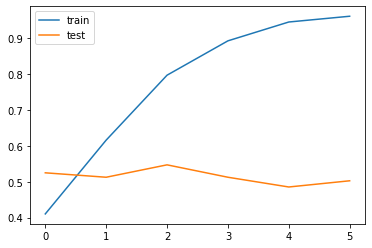

----------------------- History for f1_score -------------------------


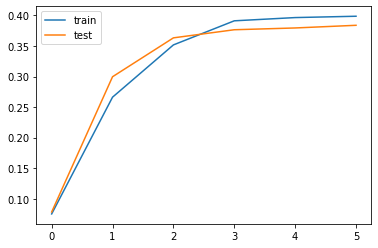

----------------------- Metrics for the last epoch -------------------------
Accuracy of train is : 0.9599507
Loss of train is : 0.1395891442750331
f1_score of train is : 0.3986337
recall of train is : 0.2489394
precision of train is : 1.0
--------
Accuracy of test is : 0.5024630427360535
Loss of test is : 2.3797585494412576
f1_score of test is : 0.3838163912296295
recall of test is : 0.23759259283542633
precision of test is : 1.0
----------------------- Metric for the best epoch -------------------------
[[ 10   0   9  56]
 [  0   0  11  21]
 [  4   0  96  74]
 [  1   0  17 107]]
Precesion:  [0.66666667        nan 0.72180451 0.41472868]
Recall:  [0.13333333 0.         0.55172414 0.856     ]
F1_score: [0.22222219        nan 0.62540712 0.55874669]
Accuracy:  0.5246305418719212


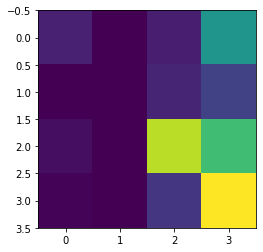

In [ ]:
print('Type 1')
history, best_model_predictions= run_model([LSTM_input_train, MLP_input_train], y_train_one_hot, [LSTM_input_test, MLP_input_test], y_test_one_hot
          ,batch_size =50, kernel_initializer= 'glorot_normal', regularizer = None
                 , dense_activity_regularizer=None, LSTM_implementation = 2, epochs = 2000
                 , dense_dropout = [0.5], lstm_dropout = [0.5], dense_neroun_count = [600]
                 , lstm_neroun_count = [100], dense_activation = ['relu'], optimizer = 'adam'
                 , other_feature_length= len(MLP_input_train[0]), patience = 5, verbose= 0)

# 60  618  618

Type 2
EMBEDDING_DIM:  300
embedding_matrix shape:  (4333, 300)
Max_Sequence_Length:  30
lstm1_neroun_count: 150 lstm2_neroun_count: 150
lstm1_dropout: 0.5 lstm2_dropout: 0.5
dense1_neroun_count: 400 dense2_neroun_count: 400 dense3_neroun_count: 400
dense1_dropout: 0.6 dense2_dropout: 0.6 dense3_dropout: 0.6
dense1_activation: relu dense2_activation: relu dense3_activation: relu
----------------------- History for accuracy -------------------------


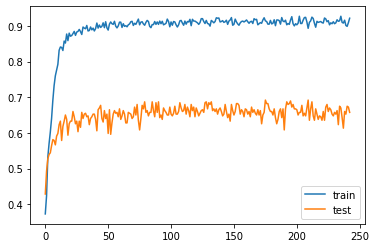

----------------------- History for f1_score -------------------------


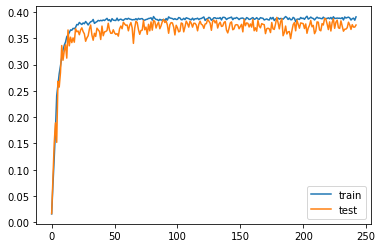

----------------------- Metrics for the last epoch -------------------------
Accuracy of train is : 0.92174983
Loss of train is : 0.498060052217118
f1_score of train is : 0.39064038
recall of train is : 0.24274296
precision of train is : 1.0
--------
Accuracy of test is : 0.6576354503631592
Loss of test is : 1.2384893083807282
f1_score of test is : 0.37517234683036804
recall of test is : 0.23099999129772186
precision of test is : 1.0
----------------------- Metric for the best epoch -------------------------
[[ 43   4  11  17]
 [  2  17   6   7]
 [ 13   4 127  30]
 [  6   1  26  92]]
Precesion:  [0.671875   0.65384615 0.74705882 0.63013699]
Recall:  [0.57333333 0.53125    0.72988506 0.736     ]
F1_score: [0.61870499 0.58620685 0.73837204 0.67896674]
Accuracy:  0.687192118226601


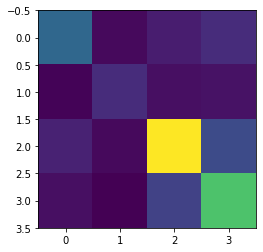

In [ ]:
print('Type 2')
history, best_model_predictions= run_model([LSTM_input_train, MLP_input_train], y_train_one_hot, [LSTM_input_test, MLP_input_test], y_test_one_hot
          ,batch_size =100, kernel_initializer= 'glorot_normal', regularizer = l2(0.01)
                 , dense_activity_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-5), LSTM_implementation = 2, epochs = 5000
                 , dense_dropout = [0.6], lstm_dropout = [0.5], dense_neroun_count = [400]
                 , lstm_neroun_count = [150], dense_activation = ['relu'], optimizer = 'rmsprop'
                 , other_feature_length= len(MLP_input_train[0]), print_summary = False, patience = 50, verbose= 0)

Type 3
EMBEDDING_DIM:  300
embedding_matrix shape:  (4333, 300)
Max_Sequence_Length:  30
lstm1_neroun_count: 100 lstm2_neroun_count: 100
lstm1_dropout: 0.6 lstm2_dropout: 0.6
dense1_neroun_count: 400 dense2_neroun_count: 400 dense3_neroun_count: 400
dense1_dropout: 0.6 dense2_dropout: 0.6 dense3_dropout: 0.6
dense1_activation: relu dense2_activation: relu dense3_activation: relu
----------------------- History for accuracy -------------------------


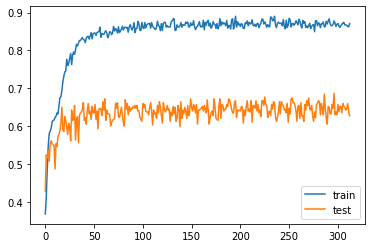

----------------------- History for f1_score -------------------------


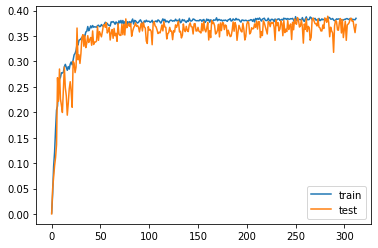

----------------------- Metrics for the last epoch -------------------------
Accuracy of train is : 0.87122613
Loss of train is : 0.6689820804863306
f1_score of train is : 0.3849652
recall of train is : 0.23838234
precision of train is : 1.0
--------
Accuracy of test is : 0.628078818321228
Loss of test is : 1.3679833688172214
f1_score of test is : 0.3727513253688812
recall of test is : 0.2291666716337204
precision of test is : 1.0
----------------------- Metric for the best epoch -------------------------
[[ 45   5  13  12]
 [  2  18  10   2]
 [ 17   2 126  29]
 [ 16   1  28  80]]
Precesion:  [0.5625     0.69230769 0.71186441 0.6504065 ]
Recall:  [0.6        0.5625     0.72413793 0.64      ]
F1_score: [0.58064511 0.62068961 0.71794867 0.64516124]
Accuracy:  0.6625615763546798


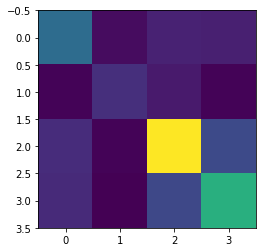

In [ ]:
print('Type 3')
history, best_model_predictions= run_model([LSTM_input_train, MLP_input_train], y_train_one_hot, [LSTM_input_test, MLP_input_test], y_test_one_hot
          ,batch_size =100, kernel_initializer= 'glorot_normal', regularizer = l2(0.018)
                 , dense_activity_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-5), LSTM_implementation = 2, epochs = 5000
                 , dense_dropout = [0.6], lstm_dropout = [0.6], dense_neroun_count = [400]
                 , lstm_neroun_count = [100], dense_activation = ['relu'], optimizer = 'rmsprop'
                 , other_feature_length= len(MLP_input_train[0]), print_summary = False, patience = 50, verbose= 0)

Type 4
EMBEDDING_DIM:  300
embedding_matrix shape:  (4333, 300)
Max_Sequence_Length:  30
lstm1_neroun_count: 125 lstm2_neroun_count: 125
lstm1_dropout: 0.6 lstm2_dropout: 0.6
dense1_neroun_count: 600 dense2_neroun_count: 600 dense3_neroun_count: 600
dense1_dropout: 0.6 dense2_dropout: 0.6 dense3_dropout: 0.6
dense1_activation: relu dense2_activation: relu dense3_activation: relu
----------------------- History for accuracy -------------------------


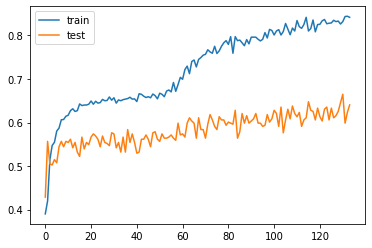

----------------------- History for f1_score -------------------------


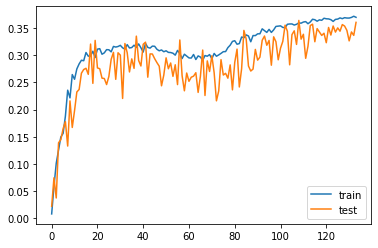

----------------------- Metrics for the last epoch -------------------------
Accuracy of train is : 0.84165126
Loss of train is : 0.8288757113931506
f1_score of train is : 0.37012112
recall of train is : 0.22714834
precision of train is : 1.0
--------
Accuracy of test is : 0.6403940916061401
Loss of test is : 1.3502260734295022
f1_score of test is : 0.36080971360206604
recall of test is : 0.2201666533946991
precision of test is : 1.0
----------------------- Metric for the best epoch -------------------------
[[ 30   4  15  26]
 [ 11  14   6   1]
 [ 14   3 125  32]
 [ 14   0  25  86]]
Precesion:  [0.43478261 0.66666667 0.73099415 0.59310345]
Recall:  [0.4       0.4375    0.7183908 0.688    ]
F1_score: [0.41666662 0.52830184 0.72463763 0.63703699]
Accuracy:  0.6280788177339901


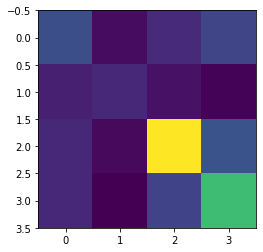

In [ ]:
print('Type 4')
history, best_model_predictions= run_model([LSTM_input_train, MLP_input_train], y_train_one_hot, [LSTM_input_test, MLP_input_test], y_test_one_hot
          ,batch_size =100, kernel_initializer= 'glorot_normal', regularizer = l2(0.02)
                 , dense_activity_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-5), LSTM_implementation = 2, epochs = 5000
                 , dense_dropout = [0.6], lstm_dropout = [0.6], dense_neroun_count = [600]
                 , lstm_neroun_count = [125], dense_activation = ['relu'], optimizer = 'rmsprop'
                 , other_feature_length= len(MLP_input_train[0]), print_summary = False, patience = 50, verbose= 0)

Type 5
EMBEDDING_DIM:  300
embedding_matrix shape:  (4333, 300)
Max_Sequence_Length:  30
lstm1_neroun_count: 125 lstm2_neroun_count: 125
lstm1_dropout: 0.6 lstm2_dropout: 0.6
dense1_neroun_count: 600 dense2_neroun_count: 600 dense3_neroun_count: 600
dense1_dropout: 0.6 dense2_dropout: 0.6 dense3_dropout: 0.6
dense1_activation: relu dense2_activation: relu dense3_activation: relu
----------------------- History for accuracy -------------------------


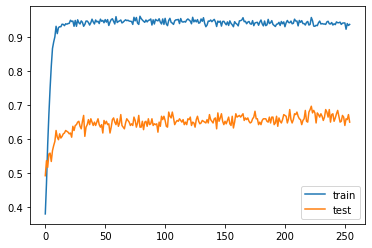

----------------------- History for f1_score -------------------------


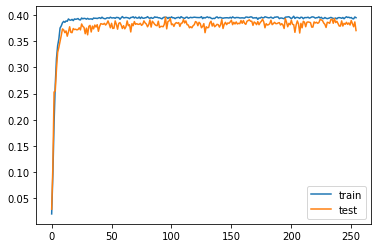

----------------------- Metrics for the last epoch -------------------------
Accuracy of train is : 0.9377696
Loss of train is : 0.3827942147052222
f1_score of train is : 0.3944537
recall of train is : 0.2456873
precision of train is : 1.0
--------
Accuracy of test is : 0.6502463221549988
Loss of test is : 1.2356786234625454
f1_score of test is : 0.3699430525302887
recall of test is : 0.22696775197982788
precision of test is : 1.0
----------------------- Metric for the best epoch -------------------------
[[ 41   5  13  16]
 [  1  21   5   5]
 [ 14   5 128  27]
 [  8   4  24  89]]
Precesion:  [0.640625   0.6        0.75294118 0.64963504]
Recall:  [0.54666667 0.65625    0.73563218 0.712     ]
F1_score: [0.58992801 0.62686562 0.744186   0.67938926]
Accuracy:  0.687192118226601


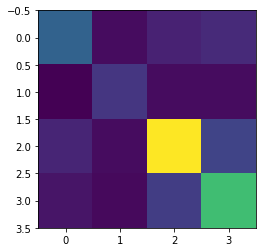

In [ ]:
print('Type 5')
history, best_model_predictions= run_model([LSTM_input_train, MLP_input_train], y_train_one_hot, [LSTM_input_test, MLP_input_test], y_test_one_hot
          ,batch_size =125, kernel_initializer= 'glorot_normal', regularizer = l2(0.005)
                 , dense_activity_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-5), LSTM_implementation = 2, epochs = 5000
                 , dense_dropout = [0.6], lstm_dropout = [0.6], dense_neroun_count = [600]
                 , lstm_neroun_count = [125], dense_activation = ['relu'], optimizer = 'rmsprop'
                 , other_feature_length= len(MLP_input_train[0]), print_summary = False, patience = 50, verbose= 0)

Type 6
EMBEDDING_DIM:  300
embedding_matrix shape:  (4333, 300)
Max_Sequence_Length:  30
lstm1_neroun_count: 125 lstm2_neroun_count: 125
lstm1_dropout: 0.6 lstm2_dropout: 0.6
dense1_neroun_count: 600 dense2_neroun_count: 600 dense3_neroun_count: 600
dense1_dropout: 0.7 dense2_dropout: 0.7 dense3_dropout: 0.7
dense1_activation: relu dense2_activation: relu dense3_activation: relu
----------------------- History for accuracy -------------------------


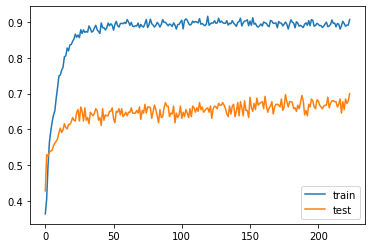

----------------------- History for f1_score -------------------------


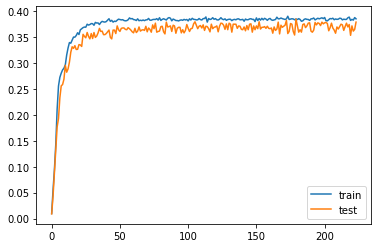

----------------------- Metrics for the last epoch -------------------------
Accuracy of train is : 0.90634626
Loss of train is : 0.5907431313893123
f1_score of train is : 0.3848588
recall of train is : 0.23829518
precision of train is : 1.0
--------
Accuracy of test is : 0.6995074152946472
Loss of test is : 1.220625005038501
f1_score of test is : 0.37854599952697754
recall of test is : 0.23348388075828552
precision of test is : 1.0
----------------------- Metric for the best epoch -------------------------
[[ 42   5  13  15]
 [  1  20   5   6]
 [ 15   4 127  28]
 [  9   4  23  89]]
Precesion:  [0.62686567 0.60606061 0.75595238 0.64492754]
Recall:  [0.56       0.625      0.72988506 0.712     ]
F1_score: [0.59154925 0.61538457 0.74269001 0.67680603]
Accuracy:  0.6847290640394089


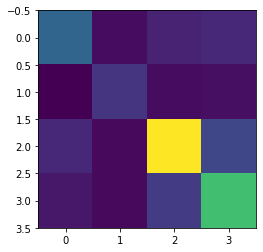

In [ ]:
print('Type 6')
history, best_model_predictions= run_model([LSTM_input_train, MLP_input_train], y_train_one_hot, [LSTM_input_test, MLP_input_test], y_test_one_hot
          ,batch_size =125, kernel_initializer= 'glorot_normal', regularizer = l2(0.009)
                 , dense_activity_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-5), LSTM_implementation = 2, epochs = 5000
                 , dense_dropout = [0.7], lstm_dropout = [0.6], dense_neroun_count = [600]
                 , lstm_neroun_count = [125], dense_activation = ['relu'], optimizer = 'rmsprop'
                 , other_feature_length= len(MLP_input_train[0]), print_summary = False, patience = 50, verbose= 0)

Type 7
EMBEDDING_DIM:  300
embedding_matrix shape:  (4333, 300)
Max_Sequence_Length:  30
lstm1_neroun_count: 125 lstm2_neroun_count: 125
lstm1_dropout: 0.6 lstm2_dropout: 0.6
dense1_neroun_count: 600 dense2_neroun_count: 600 dense3_neroun_count: 600
dense1_dropout: 0.7 dense2_dropout: 0.7 dense3_dropout: 0.7
dense1_activation: relu dense2_activation: relu dense3_activation: relu
----------------------- History for accuracy -------------------------


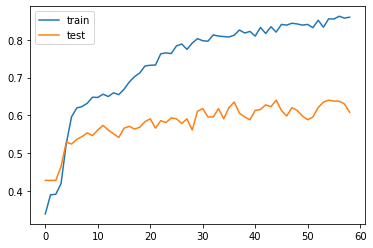

----------------------- History for f1_score -------------------------


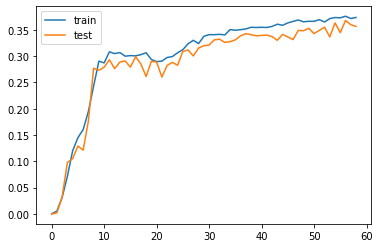

----------------------- Metrics for the last epoch -------------------------
Accuracy of train is : 0.8595194
Loss of train is : 1.2199387447524057
f1_score of train is : 0.37350512
recall of train is : 0.22965978
precision of train is : 1.0
--------
Accuracy of test is : 0.6083743572235107
Loss of test is : 1.8314422004915811
f1_score of test is : 0.35651758313179016
recall of test is : 0.21693548560142517
precision of test is : 1.0
----------------------- Metric for the best epoch -------------------------
[[  0   0  14  61]
 [  0   0   9  23]
 [  0   0 122  52]
 [  0   0  22 103]]
Precesion:  [       nan        nan 0.73053892 0.43096234]
Recall:  [0.         0.         0.70114943 0.824     ]
F1_score: [       nan        nan 0.71554247 0.56593402]
Accuracy:  0.5541871921182266


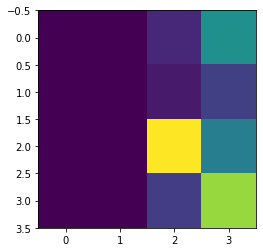

In [ ]:
print('Type 7')
history, best_model_predictions= run_model([LSTM_input_train, MLP_input_train], y_train_one_hot, [LSTM_input_test, MLP_input_test], y_test_one_hot
          ,batch_size =125, kernel_initializer= 'glorot_normal', regularizer = l2(0.015)
                 , dense_activity_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-5), LSTM_implementation = 2, epochs = 5000
                 , dense_dropout = [0.7], lstm_dropout = [0.6], dense_neroun_count = [600]
                 , lstm_neroun_count = [125], dense_activation = ['relu'], optimizer = 'adam'
                 , other_feature_length= len(MLP_input_train[0]), print_summary = False, patience = 50, verbose= 0)

Type 8
EMBEDDING_DIM:  300
embedding_matrix shape:  (4333, 300)
Max_Sequence_Length:  30
lstm1_neroun_count: 100 lstm2_neroun_count: 100
lstm1_dropout: 0.6 lstm2_dropout: 0.6
dense1_neroun_count: 600 dense2_neroun_count: 600 dense3_neroun_count: 600
dense1_dropout: 0.7 dense2_dropout: 0.7 dense3_dropout: 0.7
dense1_activation: relu dense2_activation: relu dense3_activation: relu
----------------------- History for accuracy -------------------------


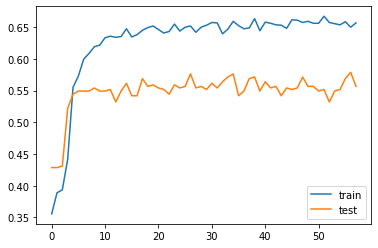

----------------------- History for f1_score -------------------------


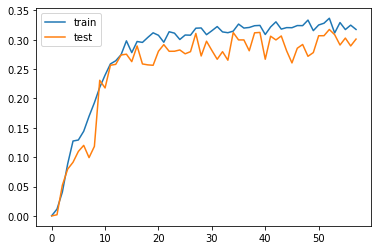

----------------------- Metrics for the last epoch -------------------------
Accuracy of train is : 0.6568084
Loss of train is : 1.356765992466638
f1_score of train is : 0.31755543
recall of train is : 0.18886189
precision of train is : 1.0
--------
Accuracy of test is : 0.5566502213478088
Loss of test is : 1.6615623958005106
f1_score of test is : 0.3011585474014282
recall of test is : 0.17733334004878998
precision of test is : 1.0
----------------------- Metric for the best epoch -------------------------
[[  0   0  14  61]
 [  0   0   6  26]
 [  0   0 122  52]
 [  0   0  24 101]]
Precesion:  [       nan        nan 0.73493976 0.42083333]
Recall:  [0.         0.         0.70114943 0.808     ]
F1_score: [       nan        nan 0.71764701 0.55342461]
Accuracy:  0.5492610837438424


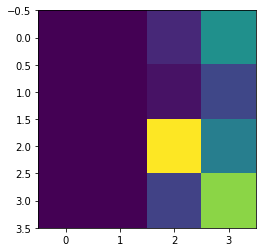

In [ ]:
print('Type 8')
history, best_model_predictions= run_model([LSTM_input_train, MLP_input_train], y_train_one_hot, [LSTM_input_test, MLP_input_test], y_test_one_hot
          ,batch_size =100, kernel_initializer= 'glorot_normal', regularizer = l2(0.02)
                 , dense_activity_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-5), LSTM_implementation = 2, epochs = 5000
                 , dense_dropout = [0.7], lstm_dropout = [0.6], dense_neroun_count = [600]
                 , lstm_neroun_count = [100], dense_activation = ['relu'], optimizer = 'adam'
                 , other_feature_length= len(MLP_input_train[0]), print_summary = False, patience = 50, verbose= 0)

https://stats.stackexchange.com/a/332136

طبق این لینک، میایم به جای کم کردن لرنینگ ریت، بچ سایز رو اضافه کنیم

Type 9
EMBEDDING_DIM:  300
embedding_matrix shape:  (4333, 300)
Max_Sequence_Length:  30
lstm1_neroun_count: 100 lstm2_neroun_count: 100
lstm1_dropout: 0.6 lstm2_dropout: 0.6
dense1_neroun_count: 600 dense2_neroun_count: 600 dense3_neroun_count: 600
dense1_dropout: 0.7 dense2_dropout: 0.7 dense3_dropout: 0.7
dense1_activation: relu dense2_activation: relu dense3_activation: relu
----------------------- History for accuracy -------------------------


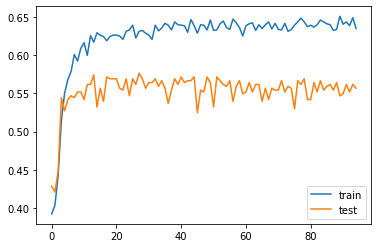

----------------------- History for f1_score -------------------------


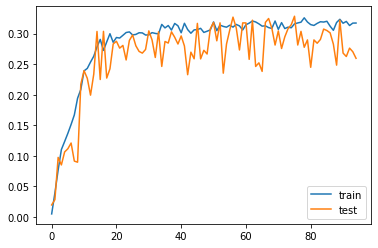

----------------------- Metrics for the last epoch -------------------------
Accuracy of train is : 0.6346272
Loss of train is : 1.1361907145452588
f1_score of train is : 0.31718832
recall of train is : 0.18856779
precision of train is : 1.0
--------
Accuracy of test is : 0.5566502213478088
Loss of test is : 1.3646817988362805
f1_score of test is : 0.2595248818397522
recall of test is : 0.15016666054725647
precision of test is : 1.0
----------------------- Metric for the best epoch -------------------------
[[  0   0  23  52]
 [  0   0  19  13]
 [  0   0 136  38]
 [  0   0  29  96]]
Precesion:  [       nan        nan 0.65700483 0.48241206]
Recall:  [0.        0.        0.7816092 0.768    ]
F1_score: [       nan        nan 0.71391071 0.59259255]
Accuracy:  0.5714285714285714


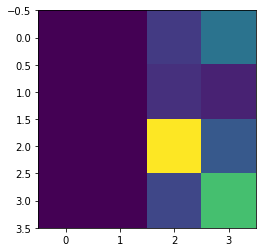

In [ ]:
print('Type 9')
history, best_model_predictions= run_model([LSTM_input_train, MLP_input_train], y_train_one_hot, [LSTM_input_test, MLP_input_test], y_test_one_hot
          ,batch_size =100, kernel_initializer= 'glorot_normal', regularizer = l2(0.02)
                 , dense_activity_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-5), LSTM_implementation = 2, epochs = 5000
                 , dense_dropout = [0.7], lstm_dropout = [0.6], dense_neroun_count = [600]
                 , lstm_neroun_count = [100], dense_activation = ['relu'], optimizer = 'rmsprop'
                 , other_feature_length= len(MLP_input_train[0]), print_summary = False, patience = 50, verbose= 0)

Type 10
EMBEDDING_DIM:  300
embedding_matrix shape:  (4333, 300)
Max_Sequence_Length:  30
lstm1_neroun_count: 125 lstm2_neroun_count: 125
lstm1_dropout: 0.6 lstm2_dropout: 0.6
dense1_neroun_count: 600 dense2_neroun_count: 600 dense3_neroun_count: 600
dense1_dropout: 0.7 dense2_dropout: 0.7 dense3_dropout: 0.7
dense1_activation: relu dense2_activation: relu dense3_activation: relu
----------------------- History for accuracy -------------------------


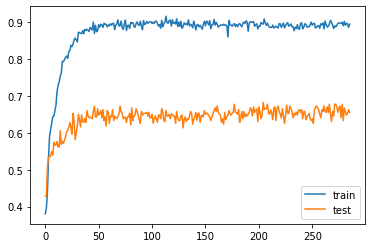

----------------------- History for f1_score -------------------------


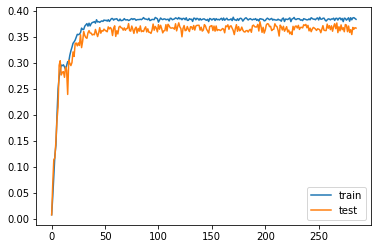

----------------------- Metrics for the last epoch -------------------------
Accuracy of train is : 0.8940234
Loss of train is : 0.6044858594919088
f1_score of train is : 0.3840997
recall of train is : 0.23771249
precision of train is : 1.0
--------
Accuracy of test is : 0.6551724076271057
Loss of test is : 1.2488890809965838
f1_score of test is : 0.36707961559295654
recall of test is : 0.2248218059539795
precision of test is : 1.0
----------------------- Metric for the best epoch -------------------------
[[ 39   4  13  19]
 [  1  20   5   6]
 [ 14   3 121  36]
 [ 11   2  26  86]]
Precesion:  [0.6        0.68965517 0.73333333 0.58503401]
Recall:  [0.52      0.625     0.6954023 0.688    ]
F1_score: [0.55714281 0.65573766 0.71386426 0.63235289]
Accuracy:  0.6551724137931034


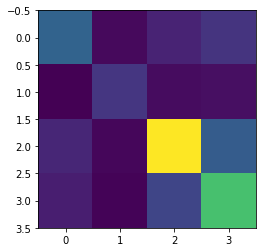

In [ ]:
print('Type 10')
history, best_model_predictions= run_model([LSTM_input_train, MLP_input_train], y_train_one_hot, [LSTM_input_test, MLP_input_test], y_test_one_hot
          ,batch_size =150, kernel_initializer= 'glorot_normal', regularizer = l2(0.01)
                 , dense_activity_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-5), LSTM_implementation = 2, epochs = 5000
                 , dense_dropout = [0.7], lstm_dropout = [0.6], dense_neroun_count = [600]
                 , lstm_neroun_count = [125], dense_activation = ['relu'], optimizer = 'rmsprop'
                 , other_feature_length= len(MLP_input_train[0]), print_summary = False, patience = 50, verbose= 0)

Type 11
EMBEDDING_DIM:  300
embedding_matrix shape:  (4333, 300)
Max_Sequence_Length:  30
lstm1_neroun_count: 125 lstm2_neroun_count: 125
lstm1_dropout: 0.6 lstm2_dropout: 0.6
dense1_neroun_count: 600 dense2_neroun_count: 600 dense3_neroun_count: 600
dense1_dropout: 0.7 dense2_dropout: 0.7 dense3_dropout: 0.7
dense1_activation: relu dense2_activation: relu dense3_activation: relu
----------------------- History for accuracy -------------------------


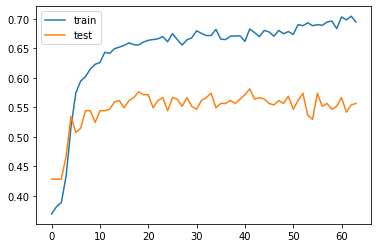

----------------------- History for f1_score -------------------------


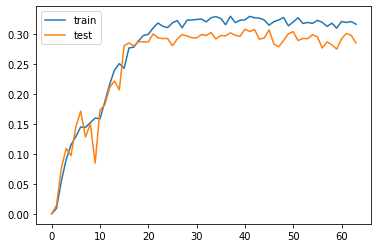

----------------------- Metrics for the last epoch -------------------------
Accuracy of train is : 0.6943931
Loss of train is : 1.0422113709661305
f1_score of train is : 0.31668448
recall of train is : 0.18817857
precision of train is : 1.0
--------
Accuracy of test is : 0.5566502213478088
Loss of test is : 1.4434121107232982
f1_score of test is : 0.28538915514945984
recall of test is : 0.16648809611797333
precision of test is : 1.0
----------------------- Metric for the best epoch -------------------------
[[  0   0  16  59]
 [  0   0   9  23]
 [  0   0 130  44]
 [  0   0  28  97]]
Precesion:  [       nan        nan 0.71038251 0.43497758]
Recall:  [0.         0.         0.74712644 0.776     ]
F1_score: [       nan        nan 0.72829127 0.55747122]
Accuracy:  0.5591133004926109


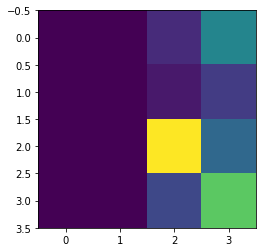

In [ ]:
print('Type 11')
history, best_model_predictions= run_model([LSTM_input_train, MLP_input_train], y_train_one_hot, [LSTM_input_test, MLP_input_test], y_test_one_hot
          ,batch_size =175, kernel_initializer= 'glorot_normal', regularizer = l2(0.015)
                 , dense_activity_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-5), LSTM_implementation = 2, epochs = 5000
                 , dense_dropout = [0.7], lstm_dropout = [0.6], dense_neroun_count = [600]
                 , lstm_neroun_count = [125], dense_activation = ['relu'], optimizer = 'rmsprop'
                 , other_feature_length= len(MLP_input_train[0]), print_summary = False, patience = 50, verbose= 0)